In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model

In [17]:
images_path = "drawings\\wave\\new_test\\healthy"

path = Path(images_path)
files = list(path.glob('*'))
print(files)

[WindowsPath('drawings/wave/new_test/healthy/V01HO01.png'), WindowsPath('drawings/wave/new_test/healthy/V02HO01.png')]


### Check image size

In [3]:
def get_image_size(image_path):
    try:
        img = Image.open(image_path)
        width, height = img.size
        return width, height
    except IOError as e:
        print(f"Unable to open image: {e}")
        return None, None

 # Replace with the actual path to your image
width, height = get_image_size('drawings\\wave\\training\\healthy\\V01HO02.png')

if width and height:
    print(f"Image width: {width}px")
    print(f"Image height: {height}px")

Image width: 512px
Image height: 265px


### Define mode1 and image genrator 

In [4]:
classifier=Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(128, 128, 3),activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Conv2D(32,(3,3),activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(activation='relu',units=128))
classifier.add(Dense(activation='sigmoid',units=1))

In [5]:
train_datagen1 = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

test_datagen1 = ImageDataGenerator(rescale = 1./255)

In [6]:
wave_train_generator1 = train_datagen1.flow_from_directory('drawings\\wave\\training',
                                                   target_size = (128,128),# Images will be resized to 128x128 pixels
                                                   batch_size = 32,
                                                   class_mode = 'binary')

wave_test_generator1 = test_datagen1.flow_from_directory('drawings\\wave\\testing',
                                                   target_size = (128,128), # Images will be resized to 128x128 pixels
                                                   batch_size = 32,
                                                   class_mode = 'binary')

Found 72 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [7]:
#define training varable 

'''
EarlyStopping: This callback monitors the validation loss and stops training when the validation loss stops improving. It helps prevent overfitting by stopping training early if the model's performance on the validation data plateaus. The parameters you've used are:

monitor='val_loss': The metric to monitor for improvement.
min_delta=0: The minimum change in the monitored metric to be considered as an improvement.
patience=3: The number of epochs with no improvement after which training will be stopped.
verbose=1: Print messages about early stopping.
restore_best_weights=True: Restore the model's weights to the best ones when stopping.
'''

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

'''
ReduceLROnPlateau: This callback reduces the learning rate when the validation loss plateaus. Lowering the learning rate can help the model converge better in later stages of training. The parameters you've used are:

monitor='val_loss': The metric to monitor for improvement.
factor=0.2: The factor by which the learning rate will be reduced.
patience=3: The number of epochs with no improvement after which the learning rate will be reduced.
verbose=1: Print messages about the learning rate reduction.
min_delta=0.0001: The minimum change in the monitored metric to be considered as an improvement.
'''

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,reduce_learningrate]

epochs = 48

classifier.compile(loss='binary_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [8]:
#train the model
history = classifier.fit_generator(
        wave_train_generator1,
        steps_per_epoch=wave_train_generator1.n//wave_train_generator1.batch_size,
        epochs=48,
        validation_data=wave_test_generator1,
        validation_steps=wave_test_generator1.n//wave_test_generator1.batch_size,
        callbacks=callbacks_list)

C:\Users\Taqana\AppData\Local\Temp\ipykernel_14896\2007578884.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(


Epoch 1/48
2/2 [==============================] - 4s 1s/step - loss: 1.6143 - accuracy: 0.5469 - lr: 0.0010
Epoch 2/48
2/2 [==============================] - 2s 1s/step - loss: 0.7128 - accuracy: 0.5500 - lr: 0.0010
Epoch 3/48
2/2 [==============================] - 1s 234ms/step - loss: 0.6921 - accuracy: 0.5750 - lr: 0.0010
Epoch 4/48
2/2 [==============================] - 1s 843ms/step - loss: 0.7005 - accuracy: 0.5250 - lr: 0.0010
Epoch 5/48
2/2 [==============================] - 1s 941ms/step - loss: 0.6823 - accuracy: 0.5750 - lr: 0.0010
Epoch 6/48
2/2 [==============================] - 2s 702ms/step - loss: 0.7015 - accuracy: 0.5156 - lr: 0.0010
Epoch 7/48
2/2 [==============================] - 1s 936ms/step - loss: 0.6944 - accuracy: 0.5000 - lr: 0.0010
Epoch 8/48
2/2 [==============================] - 1s 247ms/step - loss: 0.6878 - accuracy: 0.5500 - lr: 0.0010
Epoch 9/48
2/2 [==============================] - 1s 254ms/step - loss: 0.6844 - accuracy: 0.5750 - lr: 0.0010
Epoch 1

### Plot image traing result

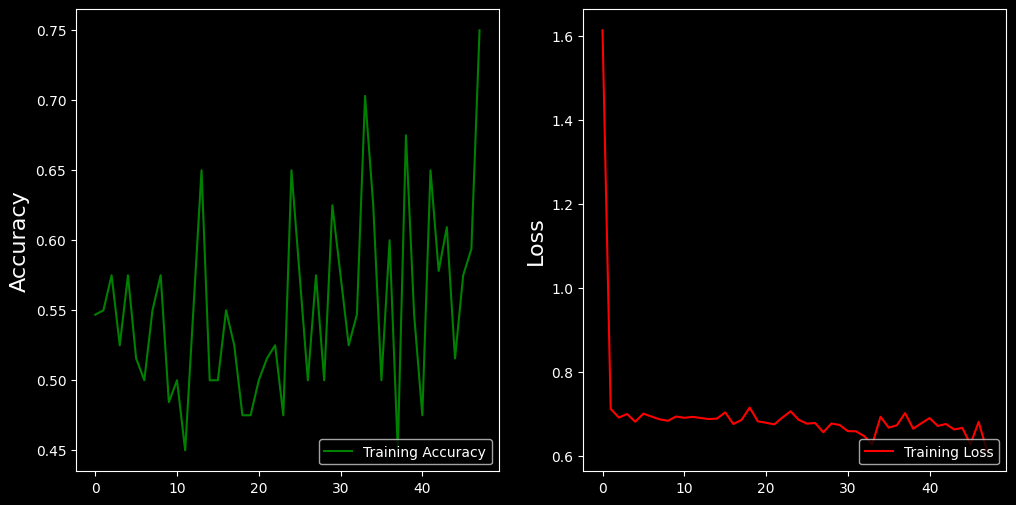

In [11]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy', color = 'green')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss', color = 'red')
plt.legend(loc='lower right')
plt.show()

# Save and load the model

In [14]:
classifier.save('my_model.h5')  # Saves the model to a HDF5 file


c:\Users\Taqana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
#lode the model
classifier = load_model('my_model.h5')

# use the model

In [19]:
# Load and preprocess a new image
new_image_path ='drawings//wave//new_test//healthy//V01HO01.png'

def preprocess_img(new_image_path):
     new_image = Image.open(new_image_path).convert("RGB")  # Ensure the image has 3 channels
     new_image = new_image.resize((128, 128))  # Resize to the target size
     new_image_array = np.array(new_image)
     new_image_array = np.expand_dims(new_image_array, axis=0)
     new_image_array = new_image_array.astype('float32') / 255.0  # Normalize the pixel values
     return(new_image_array)
# Make predictions
prediction = classifier.predict(preprocess_img(new_image_path))

1/1 [==============================] - 0s 215ms/step


In [20]:
prediction

array([[0.58663833]], dtype=float32)

In [21]:
# Get the class indices from the data generator
class_indices = wave_train_generator1.class_indices

# Reverse the dictionary to get class names from indices
class_names = {v: k for k, v in class_indices.items()}

print("Class Names:", class_names)


Class Names: {0: 'healthy', 1: 'parkinson'}
